# Housing price Analysis

Date: 02/03/2020

Version: 1

Environment: Python 2.7.16 and Jupyter notebook

Libraries used:
* pandas (loading data, creating dataframes, manipulating a dataframe and plotting)
* pandas.Series (One-dimensional ndarray with axis labels)
* json (Parsing JSON from strings or files)
* pandas.io.json (Normalize semi-structured JSON data into a flat table)
* matplotlib (Plotting)
* seaborn (High-level interface to Matplotlib, helping with the advanced plotting)
* numpy (Mathematical operation)
* IPython.core.display (Top-level display functions for displaying dataframe in different formats. Package is under 'style' file)
* scipy.spatial.distance (Used to calculate Mahalanobis distance)
* mpl_toolkits.mplot3d.Axes3d (Plotting 3 dimensional graphing)
* sklearn.linear_model.lineargression (Calculating linear regression)
* sklearn.model_selection.train_test_split (Splitting data into train sets and test sets)

## Introduction

Data from the real estate market can be used to analyze and predict property prices for data analysts. Property price predictions give a good indicator for proprty investors, property sellers, overall property market and even economic health of a country. 

This project requires wrangling U.S.A property sale records which is stored in an unknown format. It also has many unknown data quality issues. Task1 is about parsing the property sales data which is stored in 'data.dat'. Task2 is about auditing and cleaning the loaded data.

****

## Import libraries 

In [1]:
# import gengeral libraries
import pandas as pd
from pandas import Series
import json
from pandas.io.json import json_normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np   
from scipy.spatial import distance  
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')

In [3]:
!python --version

Python 2.7.16 :: Anaconda, Inc.


****

## Task 1:  Parsing the property sales data stored in “data.dat”


## 1.Loading data into dataframe

In [4]:
#loading data and checking the structure
with open("data.dat") as data_file:
    #dat format can be loaded as a json format
    file_data = json.load(data_file)
#file is loaded in dictionary format
print type(file_data)
file_data['houses'][0]

<type 'dict'>


{u'address': u'18810 Densmore Ave N, Shoreline, WA 98133, USA',
 u'area': {u'sqft_above': 1340,
  u'sqft_basement': 0,
  u'sqft_living/sqft_lot': u'sqft_living/sqft_lot=1340\\ 7912'},
 u'condition': 3,
 u'date': u'20140502T000000',
 u'floors': 1.5,
 u'price': 313000.0,
 u'rooms': u'Number of bathrooms: 1.5; Number of bedrooms: 3',
 u'view': 0,
 u'waterfront': 0,
 u'yr_built': 1955,
 u'yr_renovated': nan}

In [5]:
#what kind of keys the dictionary has
file_data.keys()

[u'houses']

In [6]:
#normalize and show the data
df_house=json_normalize(file_data['houses'])
#show the first row
df_house.head(1)

,address,area.sqft_above,area.sqft_basement,area.sqft_living/sqft_lot,condition,date,floors,price,rooms,view,waterfront,yr_built,yr_renovated
0,"18810 Densmore Ave N, Shoreline, WA 98133, USA",1340,0,sqft_living/sqft_lot=1340\ 7912,3,20140502T000000,1.5,313000.0,Number of bathrooms: 1.5; Number of bedrooms: 3,0,0,1955,NaN


## 2.Parsing the loaded data 

### 1.Spliting address into street, city, statezip, country

In [7]:
#split address into 4 parts
df_house['street'],df_house['city'],df_house['statezip'],df_house['country'] = df_house['address'].str.split(", ").str
df_house.head(1)

,address,area.sqft_above,area.sqft_basement,area.sqft_living/sqft_lot,condition,date,floors,price,rooms,view,waterfront,yr_built,yr_renovated,street,city,statezip,country
0,"18810 Densmore Ave N, Shoreline, WA 98133, USA",1340,0,sqft_living/sqft_lot=1340\ 7912,3,20140502T000000,1.5,313000.0,Number of bathrooms: 1.5; Number of bedrooms: 3,0,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA


Some columns have the issue that the order of bathrooms and bedrooms are misplaced. Some rows have issues that the number of bedrooms and number of bathrooms are misplaced. 

In [8]:
#switch the number of bathrooms and the number of bedrooms' position 
room_list=[]
for each in df_house['rooms']:
    temp=""
    #split with '; ' and convert string to list
    each_list=each.split('; ')
    #if 'number of bedrooms' shows at first, switch its position
    if "Number of bedrooms" in each_list[0]:
        temp=each_list[0]
        each_list[0],each_list[1]=each_list[1],temp
    #convert list to string
    each_str='; '.join(each_list)
    #append to whole list
    room_list.append(each_str)
#change the value of columns
df_house['rooms']=room_list
df_house.head(1)

,address,area.sqft_above,area.sqft_basement,area.sqft_living/sqft_lot,condition,date,floors,price,rooms,view,waterfront,yr_built,yr_renovated,street,city,statezip,country
0,"18810 Densmore Ave N, Shoreline, WA 98133, USA",1340,0,sqft_living/sqft_lot=1340\ 7912,3,20140502T000000,1.5,313000.0,Number of bathrooms: 1.5; Number of bedrooms: 3,0,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA


### 2.Splitting living and land area and Splitting rooms

In [9]:
#split sqft_living and lot
df_house['sqft_living'], df_house['sqft_lot'] = df_house['area.sqft_living/sqft_lot'].str.split("\ ",1).str
#extract sqft_living and sqft_lot  
df_house['sqft_living'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+',value=r'')

#split room by '; '
df_house['bathrooms'], df_house['bedrooms'] = df_house['rooms'].str.split(';', 1).str
#extract bathrooms and bedrooms 
df_house['bathrooms'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+',value=r'')
df_house['bedrooms'].replace(regex=True,inplace=True,to_replace=r'[^\d.]+',value=r'')

#show the first row
df_house.head(1)

,address,area.sqft_above,area.sqft_basement,area.sqft_living/sqft_lot,condition,date,floors,price,rooms,view,...,yr_built,yr_renovated,street,city,statezip,country,sqft_living,sqft_lot,bathrooms,bedrooms
0,"18810 Densmore Ave N, Shoreline, WA 98133, USA",1340,0,sqft_living/sqft_lot=1340\ 7912,3,20140502T000000,1.5,313000.0,Number of bathrooms: 1.5; Number of bedrooms: 3,0,...,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA,1340,7912,1.5,3


In [10]:
#remove original columns
df_house.drop(['address','area.sqft_living/sqft_lot', 'rooms'], axis = 1, inplace = True)
df_house.head(1)

,area.sqft_above,area.sqft_basement,condition,date,floors,price,view,waterfront,yr_built,yr_renovated,street,city,statezip,country,sqft_living,sqft_lot,bathrooms,bedrooms
0,1340,0,3,20140502T000000,1.5,313000.0,0,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA,1340,7912,1.5,3


### 3. Integrate and reorder column names. Make dataframe looks more tidy.

In [11]:
#rename columns' name to corresponding table name required by question
df_house.rename(columns={'area.sqft_above':'sqft_above'}, inplace=True)
df_house.rename(columns={'area.sqft_basement':'sqft_basement'}, inplace=True)
#reorder the columns
df_house = df_house[['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living','sqft_lot','floors','waterfront','view',
                    'condition','sqft_above','sqft_basement','yr_built','yr_renovated','street','city','statezip','country']]

df_house.head(1)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,20140502T000000,313000.0,3,1.5,1340,7912,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA


### 4. Change data types

In [12]:
#change data types
df_house['price'] = df_house['price'].astype(int)
df_house['bedrooms'] = df_house['bedrooms'].astype(int)
df_house['bathrooms'] = df_house['bathrooms'].astype(float)
df_house['sqft_living'] = df_house['sqft_living'].astype(int)
df_house['sqft_lot'] = df_house['sqft_lot'].astype(int)
df_house.head(1)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,20140502T000000,313000,3,1.5,1340,7912,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA


****

# Task 2. Auditing and cleansing the loaded data

## General anaysis

Let's see the value of attributes with numbers.

In [13]:
df_house.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.601000e+03,4601.000000,4601.000000,4601.000000,4.601000e+03,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,229.000000
mean,5.345240e+05,3.400782,2.160763,2139.218865,1.485157e+04,1.512171,0.007172,0.240600,3.451641,1827.448598,312.013693,1970.790263,1995.707424
std,5.716016e+05,0.908769,0.783810,963.087096,3.588059e+04,0.538278,0.084395,0.778328,0.677189,862.164780,464.109581,29.729829,18.590155
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,1912.000000
25%,3.099500e+05,3.000000,1.750000,1460.000000,5.001000e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,1988.000000
50%,4.535000e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,2001.000000
75%,6.500000e+05,4.000000,2.500000,2620.000000,1.100000e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,2009.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


What the table above tells us:

1. Each Column has 4601 data. yr_renovated has a lot of missing values
2. For the column of price, standard deviation is relatively close to mean, which indicates individual price varies a lot, it might has outliers.
3. We can see that minimum price is 0 and maximum price is 2.659x10^7, and mean is 5.34x10^7, which indicates that most of housing price are under the mean, the distribution of the price must be right skwed. 
4. For sqft_living, standard deviation is also close to mean. However, from its min and max, we can guess that the individual living area varies a lot.
5. The mean of the condition is more than 3.45. It shows that most of properties have average-above conditions.
6. Most of properties can not overlook the waterfront.
7. The properties were built between the year of 1997 and the year of 2014


Let's see the distribution of the categorical variables

In [14]:
df_house.describe(include=['O'])

,date,street,city,statezip,country
count,4601,4601,4601,4601,4601
unique,72,4525,62,77,1
top,20140623T000000,2520 Mulberry Walk NE,Seattle,WA 98103,USA
freq,142,4,1569,148,4601


What the table above tells us:

1. 142 properties have been sold at the same day
2. Aboout 80 properties (4601-4525) have been sold more than twice
3. Seattle is the most popular city for property sales
4. WA 98103 in the Seattle is the most popular area for property sales, with 148 sales in total
5. We can make sure that no other country are included in the dataset

## Checking irregularities

#### Checking irregularity of bathrooms

In [15]:
df_house.bathrooms.unique()

array([1.5 , 2.5 , 2.  , 2.25, 1.  , 1.75, 2.75, 3.  , 3.25, 3.5 , 8.  ,
       4.25, 4.  , 3.75, 5.  , 4.5 , 5.75, 1.25, 6.5 , 4.75, 0.75, 5.25,
       5.5 , 6.25, 0.  , 6.75, 1.05, 2.55, 2.57, 2.3 , 1.7 ])

From the unique bathrooms above, there are some strange numbers which do not end with .25, .5 or .75, such as 1.05, 2.55, 2.57, 2.3 and 1.7. These have no meanings in the dataset. I round them to the nearest 0.25.

In [16]:
bathroom_list=[]
for each in df_house.bathrooms:
    #rounding by quarter-intervals
    each=round(each*4)/4
    bathroom_list.append(each)
df_house['bathrooms']=bathroom_list

Now the unique number of bathrooms should be:

In [17]:
df_house.bathrooms.unique()

array([1.5 , 2.5 , 2.  , 2.25, 1.  , 1.75, 2.75, 3.  , 3.25, 3.5 , 8.  ,
       4.25, 4.  , 3.75, 5.  , 4.5 , 5.75, 1.25, 6.5 , 4.75, 0.75, 5.25,
       5.5 , 6.25, 0.  , 6.75])

#### Checking irregularity of bedrooms 

In [18]:
df_house.bedrooms.unique()

array([3, 5, 4, 2, 6, 7, 9, 1, 8, 0], dtype=int64)

Bedrooms looks good and make sense. The maximum number of bedrooms is 8 and the minimum is 0.

#### Checking irregularity of views

In [19]:
df_house.view.unique()

array([0, 4, 1, 2, 3], dtype=int64)

Views looks good and its integers are between 0 and 4.

#### Checking irregularity of condition

In [20]:
df_house.condition.unique()

array([3, 5, 4, 2, 1], dtype=int64)

Condition of property looks good and numbers are from 1 to 5.

#### Checking irregularity of yr_renovated

In [21]:
df_house.yr_renovated.unique()

array([  nan, 1994., 1954., 2011., 1998., 1958., 1992., 2005., 1986.,
       2013., 2014., 2002., 2001., 1990., 1956., 1984., 2003., 2010.,
       2000., 1996., 2007., 1970., 1983., 1981., 1971., 1988., 1999.,
       2009., 1995., 1969., 1997., 1989., 1982., 2006., 1985., 1993.,
       1953., 1955., 1979., 1987., 1960., 1934., 1945., 2008., 1980.,
       2012., 1972., 1948., 1978., 2004., 1968., 1991., 1974., 1913.,
       1912., 1923., 1977., 1975.])

In addition to NaN values, the year looks normal.

#### Checking irregularity of statezip

In [22]:
df_house.statezip.unique()

array([u'WA 98133', u'WA 98119', u'WA 98042', u'WA 98008', u'WA 98052',
       u'WA 98115', u'WA 98038', u'WA 98045', u'WA 98155', u'WA 98105',
       u'WA 98074', u'WA 98106', u'WA 98007', u'WA 98092', u'WA 98198',
       u'WA 98006', u'WA 98102', u'WA 98011', u'WA 98125', u'WA 98003',
       u'WA 98136', u'WA 98033', u'WA 98029', u'WA 98117', u'WA 98034',
       u'WA 98072', u'WA 98023', u'WA 98107', u'WA 98166', u'WA 98116',
       u'WA 98024', u'WA 98055', u'WA 98077', u'WA 98027', u'WA 98059',
       u'WA 98075', u'WA 98014', u'WA 98065', u'WA 98199', u'WA 98053',
       u'WA 98058', u'WA 98122', u'WA 98103', u'WA 98112', u'WA 98005',
       u'WA 98118', u'WA 98177', u'WA 98004', u'WA 98019', u'WA 98144',
       u'WA 98168', u'WA 98001', u'WA 98056', u'WA 98146', u'WA 98028',
       u'WA 98148', u'WA 98057', u'WA 98040', u'WA 98010', u'WA 98051',
       u'WA 98031', u'WA 98109', u'WA 98030', u'WA 98126', u'WA 98032',
       u'WA 98178', u'WA 98288', u'WA 98108', u'WA 98070', u'WA 

Statezips looks normal, and it does not have abnormal format such as WA qj922.

#### Checking irregularity of floors

In [23]:
df_house.floors.unique()

array([1.5, 2. , 1. , 2.5, 3. , 3.5])

The minimum floor is 1, and the reason why it has decimals here is that it mighe be some of the houses which have a mezzanine or an attic, and some of them might be built on a slope.

****

## Checking lexical errors
Typo is the most common error particularly when the data entry process involves human. We use 'value_counts()' function to check if there are some unique typos.

#### Checking date attribute

In [25]:
df_house.date.value_counts().tail(5) 

20140704T000000    2
20140511T000000    2
23052014T000000    1
20140517T000000    1
20140631T000000    1
Name: date, dtype: int64

The output above shows that 
* typo 
    * 23052014T000000
    
Now showing the typo row of date:

In [26]:
df_house[df_house['date']=='23052014T000000']

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4335,23052014T000000,505000,3,2.25,1670,1596,2.0,0,0,3,1220,450,2002,NaN,3019 30th Ave W,Seattle,WA 98199,USA


The format should be 'YearMonthDay', but here it is written as 'DayMonthYear'.

In [27]:
#replace to correct one
df_house.date.replace({"23052014T000000": "20140523T000000"}, inplace=True)

In data wrangling, date is supposed to be in date format. Let's change it to the format it should be.

In [28]:
#remove 'T000000'
df_house['date'] = df_house.date.str.replace('T000000' , '')

Finding other errors in date

In [29]:
#use regular expression to check whether there are other errors in date
regex = r'''(?x)
    # Year
    (?:(?:(?:\d{2})?\d{2})
    #30-day months
    (?:(?:(?:0[469]|11)(?:30|[12][0-9]|0[1-9]))|
    #31-day months
    (?:(?:0[13578]|1[02])(?:3[01]|[12][0-9]|0[1-9]))|
    #February (29 days every year)
    (?:(?:0?2)(?:[12][0-9]|0?[1-9]))))
'''

df_house[~df_house["date"].str.match(regex)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4334,20140631,248000,3,1.0,950,9400,1.0,0,0,4,950,0,1954,NaN,3920 153rd Ave SE,Bellevue,WA 98006,USA


There is no 31st day on June, so this date might be a typo. It should be 30th instead. The correction step is shown in the next step.

In [30]:
#replace 20140631 with 20140630
df_house.date.replace({'20140631':'20140630'}, inplace=True)

Here we switch string to date format.

In [31]:
#change the datetime format
df_house['date']= pd.to_datetime(df_house['date'])

#### Checking lexical errors of city attribute

In [32]:
df_house.city.value_counts().tail(5)

Snoqualmie Pass    1
Bellvue            1
Coronation         1
Sureline           1
Auburnt            1
Name: city, dtype: int64

We should check the cities which not only appear once, but also more than once but no more than 10 times.

The errors show that 
* typos & Inconsistent spelling
        'Sureline':'Shoreline', 
        'Seatle':'Seattle','seattle':'Seattle', 'Seaattle':'Seattle', 
        "redmond":"Redmond","Redmund":"Redmond","Redmonde":"Redmond",
        'Samamish':'Sammamish', 'sammamish':'Sammamish',
        'Auburnt':'Auburn', "auburn": "Auburn",
        'Bellvue':'Bellevue', 'Belleview':'Bellevue',
        "Snogualmie":"Snoqualmie",
        "Kirklund":"Kirkland",
        "Woodenville":"Woodinville",
        "Coronation":"Carnation",
        "Issaguah": "Issaquah",

From wikipedia website, Beaux Arts Village, Inglewood-Finn Hill, and Snoqualmie Pass are cities of USA, so we keep thoses cities in the table temporarily. The rest and inconsistent <font color="blue">18</font> cities are replaced with the correct ones.

In [33]:
df_house.city.unique()

array([u'Shoreline', u'Seattle', u'Kent', u'Bellevue', u'Redmond',
       u'Maple Valley', u'North Bend', u'Lake Forest Park', u'Sammamish',
       u'Auburn', u'Des Moines', u'Bothell', u'Federal Way', u'Kirkland',
       u'Issaquah', u'Woodinville', u'Normandy Park', u'Fall City',
       u'Renton', u'Carnation', u'Snoqualmie', u'Duvall', u'Burien',
       u'Covington', u'Inglewood-Finn Hill', u'Kenmore', u'Newcastle',
       u'Mercer Island', u'Black Diamond', u'Ravensdale', u'Clyde Hill',
       u'Algona', u'Skykomish', u'Tukwila', u'Vashon', u'Yarrow Point',
       u'SeaTac', u'Medina', u'Enumclaw', u'Snoqualmie Pass', u'Pacific',
       u'Beaux Arts Village', u'Preston', u'Milton', u'seattle',
       u'Woodenville', u'Seatle', u'Seaattle', u'Redmund', u'Belleview',
       u'Bellvue', u'Samamish', u'Sureline', u'Kirklund', u'Auburnt',
       u'Snogualmie', u'Issaguah', u'Redmonde', u'Coronation', u'auburn',
       u'redmond', u'sammamish'], dtype=object)

The assumption I made here is that it is less likely to have such large amount of wrong spellings.

In [33]:
#replace with the correct spelling
df_house.city.replace({'Sureline':'Shoreline', 
                       'Seatle':'Seattle','seattle':'Seattle', 'Seaattle':'Seattle', 
                       "redmond":"Redmond","Redmund":"Redmond","Redmonde":"Redmond",
                       'Samamish':'Sammamish', 'sammamish':'Sammamish',
                       'Auburnt':'Auburn', "auburn": "Auburn",
                       'Bellvue':'Bellevue', 'Belleview':'Bellevue',
                       "Snogualmie":"Snoqualmie",
                       "Kirklund":"Kirkland",
                       "Woodenville":"Woodinville",
                       "Coronation":"Carnation",
                       "Issaguah": "Issaquah" }, inplace=True)

In [34]:
df_house.city.value_counts().tail(5)

Milton                 2
Preston                2
Beaux Arts Village     1
Inglewood-Finn Hill    1
Snoqualmie Pass        1
Name: city, dtype: int64

Now let's check the cities and its corresponding statezips. 

In [35]:
df_house[df_house.city=="Beaux Arts Village"]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1476,2014-05-28,745000,3,1.75,1490,9800,1.0,0,0,4,1140,350,1947,NaN,10637 SE 29th St,Beaux Arts Village,WA 98004,USA


We can see that this area's statezip is 'WA 98004', but from the data below, is it impossible that Beaux Arts Village and other areas have the same statezip?


In [36]:
df_house[df_house.statezip=='WA 98004'].head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
102,2014-05-05,787000,3,1.75,1330,7500,1.0,0,0,3,1330,0,1961,NaN,218 109th Ave SE,Bellevue,WA 98004,USA
227,2014-05-06,1800000,5,5.00,4490,10279,2.0,0,0,3,3930,560,2013,NaN,1435 104th Ave SE,Bellevue,WA 98004,USA
273,2014-05-07,1110000,4,1.50,2310,13300,1.0,0,0,3,1890,420,1950,NaN,9724 NE 14th St,Clyde Hill,WA 98004,USA


Now, checking "Inglewood-Finn Hill's statezip

In [37]:
df_house[df_house.city=="Inglewood-Finn Hill"]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
166,2014-05-06,425000,4,2.0,1520,7983,1.0,0,0,5,1520,0,1967,NaN,14876 Juanita Woodinville Way NE,Inglewood-Finn Hill,WA 98034,USA


In [38]:
df_house[df_house.statezip=='WA 98034'].head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
30,2014-05-02,382500,4,1.75,1560,8700,1.0,0,0,4,1560,0,1967,NaN,14104 119th Ave NE,Kirkland,WA 98034,USA
84,2014-05-05,485000,4,3.00,2340,7048,1.0,0,0,4,1340,1000,1979,NaN,14319 85th Pl NE,Kirkland,WA 98034,USA
115,2014-05-05,340000,5,1.00,1120,9022,1.5,0,0,4,1120,0,1962,NaN,14150 75th Ave NE,Kirkland,WA 98034,USA


It looks possible that Inglewood-Finn Hill shares the same statezip with the city of Kirkland.

#### Checking statezip attribute

In [39]:
df_house.statezip.value_counts().tail(3)

WA 98354    2
WA 98050    2
WA 98068    1
Name: statezip, dtype: int64

I suspect that the statezip that appears twice might have some issures. Now I check them one by one.

In [40]:
df_house[df_house.statezip=='WA 98068']

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1064,2014-05-21,525000,3,2.75,2100,10362,2.0,0,0,3,1510,590,1998,NaN,3 Ober Strasse,Snoqualmie Pass,WA 98068,USA


The corresponding city "Snoqualmie Pass" only appears once from the last city value counts. So it is not wrong.

In [41]:
df_house[df_house.statezip=='WA 98354']

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2064,2014-06-06,320000,3,1.75,1370,9900,1.0,0,0,4,1370,0,1983,NaN,99 17th Ave,Milton,WA 98354,USA
4112,2014-07-08,250000,3,1.75,1140,10400,1.0,0,0,4,1140,0,1983,NaN,1705 Douglas Ct,Milton,WA 98354,USA


The corresponding city "Milton" appears twice. So it is not wrong

In [42]:
df_house[df_house.city=="Milton"]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2064,2014-06-06,320000,3,1.75,1370,9900,1.0,0,0,4,1370,0,1983,NaN,99 17th Ave,Milton,WA 98354,USA
4112,2014-07-08,250000,3,1.75,1140,10400,1.0,0,0,4,1140,0,1983,NaN,1705 Douglas Ct,Milton,WA 98354,USA


Checking the statezip which equals 'WA 98050'

In [43]:
df_house[df_house.statezip=='WA 98050']

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1672,2014-06-02,439900,2,2.00,1410,12282,1.5,0,0,5,1410,0,1909,1988.0,31103 SE 85th Pl,Preston,WA 98050,USA
1944,2014-06-05,685000,3,2.75,3150,219978,2.0,0,0,4,3000,150,1990,NaN,5424 298th Ave SE,Preston,WA 98050,USA


In [44]:
df_house[df_house.city=="Preston"]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1672,2014-06-02,439900,2,2.00,1410,12282,1.5,0,0,5,1410,0,1909,1988.0,31103 SE 85th Pl,Preston,WA 98050,USA
1944,2014-06-05,685000,3,2.75,3150,219978,2.0,0,0,4,3000,150,1990,NaN,5424 298th Ave SE,Preston,WA 98050,USA


The corresponding city "Preston" appear twice. It is not wrong either.

***

##  Checking Inconsistency , Integrity and Semantic errors
### Checking whether the values of "sqft_living" consistent with the values of "sqft_above" plus "sqft_basement"

In [45]:
df_house.loc[(df_house.sqft_living!=df_house.sqft_above+df_house.sqft_basement)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4338,2014-07-10,670000,3,2.5,1280,1438,2.0,0,0,3,1280,1420,2003,NaN,746 Boylston Ave E,Seattle,WA 98102,USA
4339,2014-07-01,202000,1,1.0,890,833,1.0,0,0,4,590,0,1926,NaN,701-711 26th Ave,Seattle,WA 98122,USA


There are 2 properties which are not consistency. According to the first property, we can see that sqft_living and sqft_above have the same room areas, I guess it might either be a typo or someone forget to add the value of basement. It is resonable to add above and basement area together because the property has 2 levels so that sqft_living coule be larger than sqft_lot. Assume the correct sqft_living values should add area of the above and the area of the basement together.  The second property must be a typo.

In [46]:
df_house['sqft_living']=df_house['sqft_above']+df_house['sqft_basement']

### Checking whether the year of last renovation earlier than the year of its initially built

In [47]:
df_house.loc[(df_house.yr_renovated<=df_house.yr_built)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4340,2014-05-02,440000,4,2.25,2160,8119,1.0,0,0,3,1080,1080,1966,1913.0,12211 SE 65th St,Bellevue,WA 98006,USA
4341,2014-05-26,690000,4,2.50,2700,8810,2.0,0,0,3,2700,0,2004,2003.0,11659 168th Ct NE,Redmond,WA 98052,USA
4342,2014-05-08,375000,6,2.25,3206,5793,2.0,0,0,3,3206,0,2012,1912.0,25921-25929 35th Pl S,Kent,WA 98032,USA
4345,2014-05-22,850000,4,3.25,3090,6744,2.0,0,4,3,3090,0,2013,1923.0,19117-19123 Richmond Beach Dr NW,Shoreline,WA 98177,USA


There are 4 properties having typos here. Assume that someone reversed the year of renovate and the year of built, I switch them back.

In [48]:
#finding the rows that yr_renovated eairlier than yr_built
s=df_house['yr_renovated']<df_house['yr_built']
#reverse the value of 2 columns
df_house.loc[s,['yr_renovated','yr_built']]=df_house.loc[s,['yr_built','yr_renovated']].values

### Checking whether a house does not have any bathrooms and bedrooms

In [49]:
df_house[(df_house.bathrooms==0) & (df_house.bedrooms==0)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2365,2014-06-12,1095000,0,0.0,3064,4764,3.5,0,2,3,3064,0,1990.0,NaN,814 E Howe St,Seattle,WA 98102,USA
3209,2014-06-24,1295648,0,0.0,4810,28008,2.0,0,0,3,4810,0,1990.0,NaN,20418 NE 64th Pl,Redmond,WA 98053,USA


According to the above 2 properties, it is reasonable that a property does not have any bedroms and bathrooms, because yr_renovated are missing here. We can assume that these properties have not been renovated yet. And these two properties have similar price and year_built. Keeping them in the database could be a good indicator for a investor who like to buy a house without any bedroms and bathrooms. We can assume those type of properties are a 
unfurnished house and does not have any fitments and paintings. So, I keep those rows in the database.

### Checking whether a property's living area is larger than the land area when it only has 1 floor and no basement

Let's check the house which just have 1 floor

In [34]:
df_house[(df_house.floors==1)].head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2,20140502T000000,342000,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,20140502T000000,420000,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA
4,20140502T000000,550000,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA


From the table above, we cannot say that the basement area is a part of floor because when floor equals 1, a lot of properties still have a basement with large area, and obviously they are not mistakes or errors.

Now let's check whether we have a property that living area is larger than land area when the property only has 1 floor and no basement.

In [50]:
df_house[(df_house.floors==1) & (df_house.sqft_basement==0) & (df_house.sqft_living>df_house.sqft_lot)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country


Good news! It seems that no rows meet the condition.

## Checking duplicated records

If we assume that street, city and date can uniquely identify a property bacause there will not be a property sold twice in one day, we can then use the three values to check whether or not the dataset contains duplicated records.

In [51]:
df_house[df_house.duplicated(["street", "city","date"], keep=False)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1017,2014-05-20,300000,6,5.25,2860,5682,2.0,0,0,3,2860,0,1978.0,NaN,606 5th St SE,Auburn,WA 98002,USA
1024,2014-05-20,206000,4,2.00,1700,6025,1.0,0,0,3,1700,0,1978.0,NaN,606 5th St SE,Auburn,WA 98002,USA
4336,2014-05-22,657500,3,2.50,2670,10496,2.0,0,0,3,2670,0,1989.0,NaN,1917 235th Ct NE,Sammamish,WA 98074,USA
4337,2014-05-22,657500,3,2.50,2670,10496,2.0,0,0,3,2670,0,1989.0,NaN,1917 235th Ct NE,Sammamish,WA 98074,USA


The property in the street '606 5th St SE' might not be sold just once, we can check other dates to identify which one is more accurate.

In [52]:
df_house[df_house.street=='606 5th St SE']

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1017,2014-05-20,300000,6,5.25,2860,5682,2.0,0,0,3,2860,0,1978.0,NaN,606 5th St SE,Auburn,WA 98002,USA
1024,2014-05-20,206000,4,2.00,1700,6025,1.0,0,0,3,1700,0,1978.0,NaN,606 5th St SE,Auburn,WA 98002,USA


Assume that there is not any selling records here on that property, but we can check the status of other properties which have similar land area in the same city.

In [53]:
df_house[(df_house.city=='Auburn') & ((df_house.sqft_lot>5000) & (df_house.sqft_lot<7000))].head(1)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
103,2014-05-05,328000,4,2.5,2370,6500,2.0,0,0,3,2370,0,1998.0,NaN,12621 SE 300th Way,Auburn,WA 98092,USA


In [54]:
df_house[(df_house.bedrooms>5) & (df_house.bathrooms>5)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
122,2014-05-05,2280000,7,8.00,13540,307752,3.0,0,4,3,9410,4130,1999.0,NaN,26408 NE 70th St,Redmond,WA 98053,USA
291,2014-05-07,540000,7,5.75,3700,7647,2.0,0,1,3,3700,0,1948.0,1984.0,15007-15299 37th Ave NE,Lake Forest Park,WA 98155,USA
1017,2014-05-20,300000,6,5.25,2860,5682,2.0,0,0,3,2860,0,1978.0,NaN,606 5th St SE,Auburn,WA 98002,USA
3004,2014-06-20,1240000,7,5.50,6630,13782,2.0,0,0,3,4930,1700,2004.0,NaN,16659 SE 69th Way,Bellevue,WA 98006,USA


Comparing with other properies in this area, the first observation is at the street '606 5th St SE', the price for both properties are resonable. It seems to be a town house which share one address. The first proerty with higher living area has higher price, but the second one has lower living area and lower housing price. So it is reasonable to keep these houses in the table since it could happen in the real world.

In terms of the row 4336 and the row 4337, they are completely the same. I just remove the first record and keep the second one for this properties.

In [55]:
df_house.drop_duplicates(["street", "city", "date", "price"], keep='last', inplace=True)

### Now let's check the duplicate again in case we have other duplicate omissions

In [56]:
df_house[df_house.duplicated(["street", "price"], keep=False)]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2271,2014-06-10,399950,2,1.0,710,1157,2.0,0,0,4,710,0,1943.0,NaN,2358 Fairview Ave E,Seattle,WA 98102,USA
2350,2014-06-11,399950,2,1.0,710,1131,2.0,0,0,4,710,0,1943.0,NaN,2358 Fairview Ave E,Seattle,WA 98102,USA


We can find the row 2271 property sold just one day eariler than the row 2350 property. It can be regarded as a typo, but also can be seemed as reasonable rows. If we regard it as a normal case, we can say that the property had been sold in 10th June and sold at the second time at 11th June. I regard it as a normal case because it could happen in the real world even though the second owner did not gain or lose any profit. 

***

## Outliers

The reason why I remove outliers before filling missing values is that outliers will influence linear regression model as well as r-squares when predicting missing values.

###  Removing missing values

missing values should be changed to 'NaN' in case of finding outliers

Price equals 0 can be regarded as a missing value because a property can not be sold without any charge in the real property market

In [57]:
#replace 0 with NaN
df_house['price'].replace(0,np.NaN,inplace=True)

### Univariate Outlier Detection Methods
* The 3σ Edit Rule
* The Boxplots graphical Detections

##### 1.The 3σ Edit Rule

The most common way to detect outliers in this case is the 3σ edit rule, which indicates that any point lying farther than three standard deviations from the mean is an outlier. 

In [58]:
df_house['price'].describe()

count    4.352000e+03
mean     5.649557e+05
std      5.728973e+05
min      7.800000e+03
25%      3.300000e+05
50%      4.710000e+05
75%      6.600000e+05
max      2.659000e+07
Name: price, dtype: float64

In [61]:
#calculate the distance of 3*standard deviation
three_sigma=3*(df_house.price.std())
three_sigma

1718691.9460004922

In [62]:
#finding the rows that has 3sd far away from the mean
price_Editrule=[]
for i in range(len(df_house)):
    #calculate the mean of price
    price_mean=df_house.price.mean()
    #absolute value of price
    absolute_value=abs(df_house.price.iloc[i])
    #distance of 3sd away from mean
    a=price_mean+three_sigma
    #justify the price of property larger than 3sd from the mean
    if absolute_value>a:
        price_Editrule.append(i)

In [63]:
len(price_Editrule)

30

In [29]:
df_house.iloc[price_Editrule]

There are 30 outliers detected from this calculation. The basic idea of the edit rule is if the data samples are well approximated by an i.i.d. sequence of Gaussian random variables with mean μ and standard deviation σ, the probability of observing a value farther than three standard deviations from the mean is only about 0.3%. However, 30 outliers account for 0.65% of total sample properities in this case. A common difficulty for this method is the sensitivity to mean and SD value that are themselves affected by the outliers. According to this definition, we can conclude that if there is a data point farther than an outlier is also an outlier. So I would like to use other methods to check the outliers.

****

##### 2.Boxplots Detection

Graphical methods are very important for visualising and identifying outliers especially with data represented in few dimensions. Boxplot is a common graphical method that has an advantage of robustness against outliers because it is the usage of quartiles. 

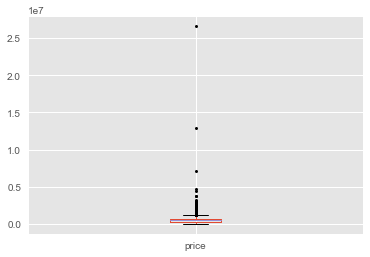

In [65]:
df_house.boxplot(column='price',sym='k.')
plt.show()

In [66]:
df_house['price'].describe()

count    4.352000e+03
mean     5.649557e+05
std      5.728973e+05
min      7.800000e+03
25%      3.300000e+05
50%      4.710000e+05
75%      6.600000e+05
max      2.659000e+07
Name: price, dtype: float64

From the boxplot and price description above, we can see that the y-axis is shown in million. The median value is shown at the bottom in the box plot. It is hard to distinguish any deviation below the median. Therefore, we take the natural log of the house prices to look for any clear deviation.

In [59]:
#log of each price
df_house['price']=np.log(df_house.price)

In [61]:
#show the first 5 rows
df_house.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,12.653958,3,1.5,1340,7912,1.5,0,0,3,1340,0,1955.0,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,14.684290,5,2.5,3650,9050,2.0,0,4,5,3370,280,1921.0,NaN,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02,12.742566,3,2.0,1930,11947,1.0,0,0,4,1930,0,1966.0,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA


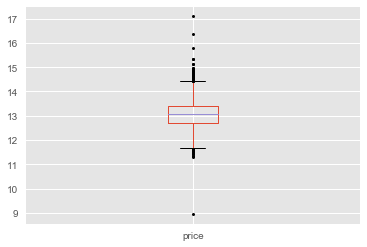

In [69]:
#Now plot a boxplot again
df_house.boxplot(column='price',sym='k.')
plt.show()

From the boxplot shows above, we can clearly find the outliers are biased from the median

In [70]:
#checking the price which lower than 10 after logarithm
df_house[df_house.price<10]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4352,2014-05-06,8.961879,2,1.0,780,16344,1.0,0,0,1,780,0,1942,NaN,4229 S 144th St,Tukwila,WA 98168,USA


This is a weired price for a property. We can see that the land area is quite large but living area is quite small. Also, it has the least condition and only 2 bedrooms. There is a large probability that a mistake occur either in price or in land area. Therefore, this data must be an outlier here.

In [71]:
#checking the price which higher than 15.5
df_house[df_house.price>15.5]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
2286,2014-06-11,15.770310,5,4.5,10040,37325,2.0,1,2,3,7680,2360,1940,2001.0,4442 95th Ave NE,Bellevue,WA 98004,USA
4347,2014-06-23,16.372660,3,2.5,2190,11394,1.0,0,0,3,1550,640,1956,NaN,5426 40th Ave W,Seattle,WA 98199,USA
4351,2014-07-03,17.096046,3,2.0,1180,7793,1.0,0,0,4,1180,0,1992,NaN,12005 SE 219th Ct,Kent,WA 98031,USA


From the above first obervation, the property with the highest price is resonable because it has larger living and land area, and mulitiple bedrooms and bathrooms. More importantly, it was renovated in 2001. I would like to check the location in the next step.

In terms of the second observation, I guess the reason why the price is way too high is because of the larger land area and the better location.

The third oservation which has higher property price seems also reasonable because this property has higher land area, higher condition and was built relatively late even though the living area is relatively small.

let's check wthether the location can influence the housing price

In [64]:
df_house[df_house.city=='Bellevue'].describe()['price']

count    265.000000
mean      13.563497
std        0.461470
min       12.421184
25%       13.217674
50%       13.520468
75%       13.842152
max       15.770310
Name: price, dtype: float64

In [65]:
df_house['price'].describe()

count    4352.000000
mean       13.079388
std         0.537775
min         8.961879
25%        12.706848
50%        13.062613
75%        13.399995
max        17.096046
Name: price, dtype: float64

We can see that the mean price (13.56) is higher than the market mean(13.07). It gives us a persuadable evidence that the location is the one of the reason that will influence the housing price. Therefore, the highest price of the property could be reasonable but just be further from the mean phousing price.

****

### ● Multivariate Outlier Detection Methods
* Graphical method
* Mahalanobis Distance

##### 1. Graphical method

According to the previous boxplot anaysis, price has relationship with some measured variables. We check whether the <font color="blue">location</font> is one of the factors that will influence the housing price.

When detecting relationship between the hosing price and the location, we attempt to minimize the impacts from other factors. I calculate the price per living area for each city and then compare them with the volatility of the housing price. 

In [73]:
#create a column that calculate price per living area
df_house['price_living']=df_house['price']/df_house['sqft_living']

In [74]:
df_house.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price_living
0,2014-05-02,12.653958,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA,0.009443
1,2014-05-02,14.684290,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA,0.004023
2,2014-05-02,12.742566,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA,0.006602
3,2014-05-02,12.948010,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA,0.006474
4,2014-05-02,13.217674,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA,0.006813


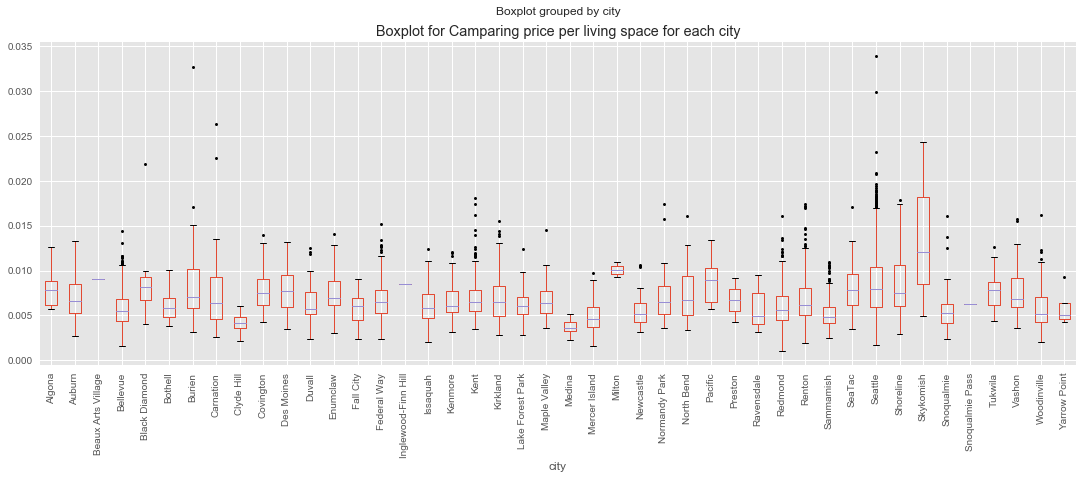

In [75]:
#draw boxplot
#using price group by city to plot a boxplot, shows outliers and figure size is 18,6, convert x_axis and y_axis
df_house.boxplot(column="price_living", by='city', sym = 'k.', rot=90,figsize=(18,6))
#set title
plt.title('Boxplot for Camparing price per living space for each city')
plt.show()

In [76]:
df_house[df_house.price_living>0.025]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price_living
1219,2014-05-23,11.289782,1,0.75,430,5050,1.0,0,0,2,430,0,1912,NaN,32215 E Rutherford St,Carnation,WA 98014,USA,0.026255
2416,2014-06-12,12.542545,1,0.75,420,6720,1.0,0,0,3,420,0,1922,NaN,5550 17th Ave S,Seattle,WA 98108,USA,0.029863
2919,2014-06-20,12.409013,1,0.75,380,15000,1.0,0,0,3,380,0,1963,NaN,13602 8th Ave S,Burien,WA 98168,USA,0.032655
3778,2014-07-01,12.528156,1,0.75,370,1801,1.0,0,0,5,370,0,1923,NaN,2508 NW 67th St,Seattle,WA 98117,USA,0.033860


From the graph we can see Skykomish has the highest price per living area and Medina has the lowest. There are searval properties in Seattle which are also expensive. 

In the USA or most of other contries, housing price does not only depend on the living area. Other factors are also need to be considered such as interest rate, neigborhood etc. Now I draw a boxplot to compare each city's median price.

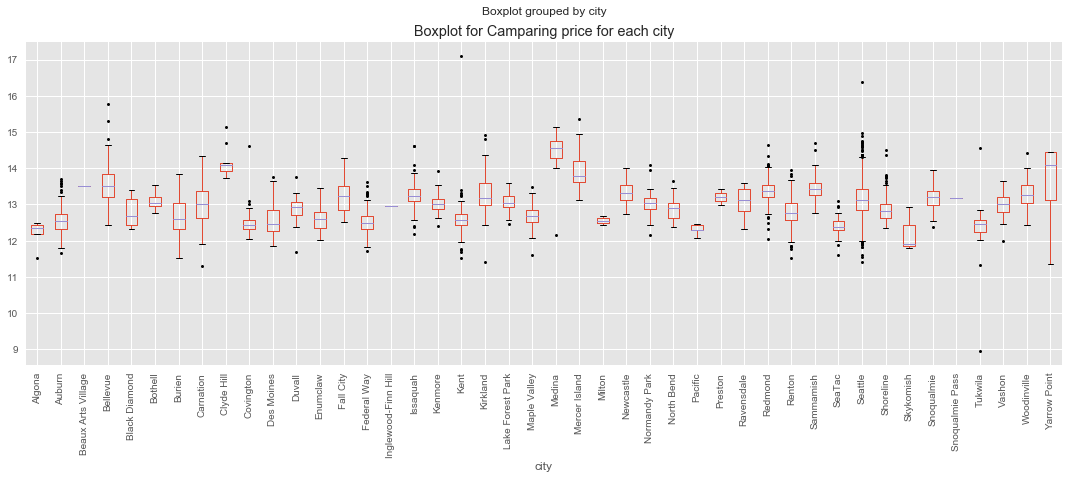

In [77]:
#draw boxplot
#build a boxplot for city and price
df_house.boxplot(column="price", by='city', sym = 'k.', rot=90, figsize=(18,6))
#set title
plt.title('Boxplot for Camparing price for each city')
plt.show()

We can see the output is totally different from the price per living area. Skykomish has the lowst median price among the 44 cities but it has the highest median price per living area. This indicates that Skykomish is a city where has relatively experensive hosing price but smaller living area. In other words, people who live there need to pay more to buy a relatively smaller house compared to the buyers who live in other cities.

In terms of the city "Tukwila", there is a house which has the lowest housing price. However, by checking the highest price of the city, it seems too far away from median price. I would regard the lowest one as an outlier.

From eyeballing, The outliers should be as following:

In [78]:
df_house[(df_house.price>16) | (df_house.price<10) | ((df_house.city=='Tukwila') & (df_house.price>14))]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price_living
4347,2014-06-23,16.372660,3,2.5,2190,11394,1.0,0,0,3,1550,640,1956,NaN,5426 40th Ave W,Seattle,WA 98199,USA,0.007476
4348,2014-05-08,14.562199,4,1.0,2100,9200,1.0,0,0,3,1050,1050,1959,NaN,14070 Military Rd S,Tukwila,WA 98168,USA,0.006934
4351,2014-07-03,17.096046,3,2.0,1180,7793,1.0,0,0,4,1180,0,1992,NaN,12005 SE 219th Ct,Kent,WA 98031,USA,0.014488
4352,2014-05-06,8.961879,2,1.0,780,16344,1.0,0,0,1,780,0,1942,NaN,4229 S 144th St,Tukwila,WA 98168,USA,0.011490


According to the boxplot above, city is a factor affecting housing prices. I thought the easiest way was to use dummy variables to represent cities. But this method has a difficulty -- we need to generate 11 extra city columns, but it might cause Spurious Regression when we predict the housing price. 

So I seperate cities into 4 groups based on the price, and each group has 11 cities (because some of cities just has 1 property recorded, seperating 11 cities may influence predictions). And those groups are used for predicitng missing values later. 

In [79]:
#build a dataframe including price and city
df_price_city=df_house[['price','city']]
city_median_list={}
for each in df_house.city.unique().tolist():
    #counting median price for each city
    count_median=df_price_city[df_price_city.city==each]['price'].median()
    #median value as a key, city as a value
    city_median_list[count_median]=each

In [30]:
city_median_list

In [81]:
#total number of cities
len(city_median_list)

44

In [82]:
city_list=[]
#sort median price from lowest to highest 
for key in sorted(city_median_list.keys()):
    city_list.append(city_median_list[key])
#the first 11 cities are regarded as lowest housing price cities
lowest_price_cities=city_list[:11]
#the 11th to 22nd cities are regarded as lower housing price cities
low_price_cities=city_list[11:22]
#the 22nd to 33rd cities are regarded as higher housing price cities
high_price_cities=city_list[22:33]
#the last 11 cities are regarded as highest housing price cities
highest_price_cities=city_list[33:44]

##### 2. Mahalanobis Distance

The second method is to use Mahalanobis distance to find the outliers. Let's look at the correlation between price and other values. 

In [83]:
df_house.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,price_living
price,1.000000,0.357069,0.551150,0.684202,0.095549,0.306321,0.146005,0.336901,0.065030,0.594455,0.318014,0.054128,0.144841,-0.547608
bedrooms,0.357069,1.000000,0.545870,0.594884,0.068819,0.177895,-0.003483,0.111028,0.025080,0.484705,0.334165,0.139581,0.113296,-0.630964
bathrooms,0.551150,0.545870,1.000000,0.761174,0.107868,0.486438,0.076241,0.211999,-0.120046,0.689886,0.298124,0.462092,0.211669,-0.697498
sqft_living,0.684202,0.594884,0.761174,1.000000,0.210538,0.344850,0.117616,0.311009,-0.062826,0.876443,0.447206,0.286110,0.116311,-0.824032
sqft_lot,0.095549,0.068819,0.107868,0.210538,1.000000,0.003750,0.017241,0.073907,0.000558,0.216455,0.034842,0.051079,-0.192180,-0.152166
floors,0.306321,0.177895,0.486438,0.344850,0.003750,1.000000,0.022024,0.031211,-0.275013,0.522814,-0.255510,0.466268,0.056934,-0.322573
waterfront,0.146005,-0.003483,0.076241,0.117616,0.017241,0.022024,1.000000,0.360935,0.000352,0.078911,0.097501,-0.023396,-0.030691,-0.042327
view,0.336901,0.111028,0.211999,0.311009,0.073907,0.031211,0.360935,1.000000,0.063077,0.174327,0.321602,-0.067250,0.008970,-0.199041
condition,0.065030,0.025080,-0.120046,-0.062826,0.000558,-0.275013,0.000352,0.063077,1.000000,-0.178196,0.200632,-0.398239,-0.440893,0.049823
sqft_above,0.594455,0.484705,0.689886,0.876443,0.216455,0.522814,0.078911,0.174327,-0.178196,1.000000,-0.038723,0.406456,0.078825,-0.718322


The numbers makes people feel headache, correlation matrx can help to clearly identify the correlations.

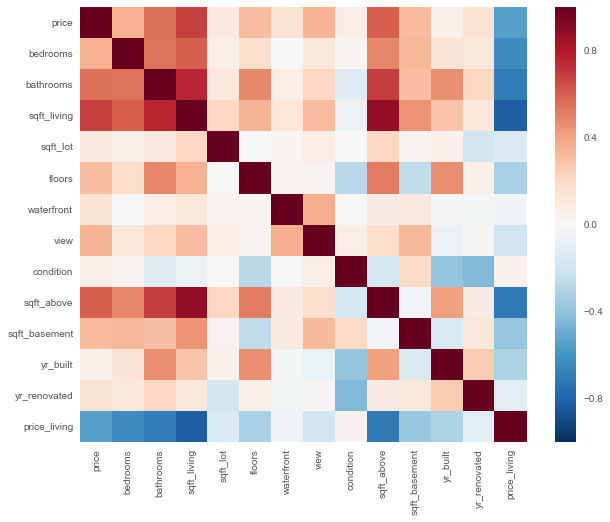

In [84]:
plt.figure(figsize=(10,8))
corr = df_house.corr()
#use seaborn to draw the headmap
sns.heatmap(corr, 
            xticklabels=corr.columns.values, #x label
            yticklabels=corr.columns.values) #y label
plt.show()

Correlation gives an indication of how related the changes are between two variables. If two variables change in the same direction, they are positively correlated. If the change in the opposite direction (one goes up, one goes down), then they are negatively correlated. From correlation matrix, positive correlations are displayed in red and negative correlations are displayed in blue. The most correlated variables are living areas and bathrooms. 

Here, we would like to use Mahalanobis Distance to find outliers. The prerequisites of using Mahalanobis Distance is to enusre variables are normally distributed. 

Generally, in the real word, the total market housing price and its corresponding living areas should be normally distributed. A histgram can be plotted both for price and living areas. Let's check whether they are normally distributed.

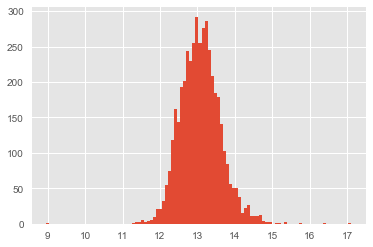

In [85]:
#plot a price histgram
df_house['price'].hist(bins=100)
plt.show()

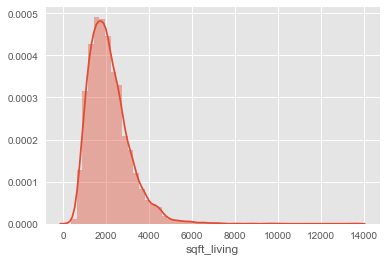

In [86]:
#plot living area histogram
sns.distplot(df_house['sqft_living'])
plt.show()

Now we are going to gengerate 2-dimention mahalanobis distance for detecting outliers.

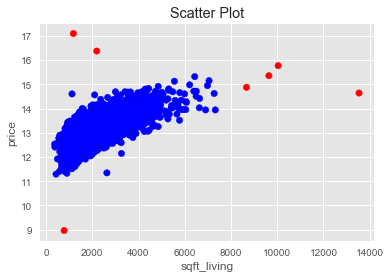

In [87]:
#2-dimention mahalanobis distance detect outliers
#The greater the value of mahalanobis distance, the higher probability of outlier it is.

#build a new dataframe which contains juat column for price and sqft_living 
hw=df_house[['price','sqft_living']]
#define number of outliers
n_outliers =7
#use mahalanobis distance to detect each point
#series used to generate distance for each property
#hw.iloc stands for the outside index of each row; hw.mean stands for value of mean for 2 columns; np.mat create correlation matrix and reverse the matrix
m_dist_order = Series([float(distance.mahalanobis(hw.iloc[i], hw.mean(), np.mat(hw.cov().as_matrix()).I) ** 2) for i in range(len(hw))]).sort_values(ascending=False).index.tolist()  
#If the property is outlier return True, otherwise return False
is_outlier = [False, ] * (len(hw)) 
for i in range(n_outliers):  
    is_outlier[m_dist_order[i]] = True 
#outliers are displayed in red, others are displayed in blue
color = ['b', 'r']  
#turn True to 1, False to 0
pch = [1 if is_outlier[i] == True else 0 for i in range(len(is_outlier))]  
#turn 1 to 'r', turn 0 to 'b'
cValue = [color[is_outlier[i]] for i in range(len(is_outlier))]  

#plotting
fig = plt.figure()  
#set title
plt.title('Scatter Plot')  
#set x label
plt.xlabel('sqft_living')  
#set y label
plt.ylabel('price')  
#draw scatter
plt.scatter(hw['sqft_living'],  hw['price'], s=40, c=cValue) 
plt.show()  

In [88]:
index_list1=[]
for i in range(len(pch)):
    #if value in pch is 1, it is an outlier
    if pch[i]==1:
        index_list1.append(i)

In [89]:
index_list1

[122, 2286, 2328, 2654, 4346, 4350, 4351]

The outliers found from 2-dimention mahalanobis distance showed as following:

In [90]:
#show outliers from 2-dimention mahalanobis distance
df_house.iloc[index_list1]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price_living
122,2014-05-05,14.639686,7,8.00,13540,307752,3.0,0,4,3,9410,4130,1999,NaN,26408 NE 70th St,Redmond,WA 98053,USA,0.001081
2286,2014-06-11,15.770310,5,4.50,10040,37325,2.0,1,2,3,7680,2360,1940,2001.0,4442 95th Ave NE,Bellevue,WA 98004,USA,0.001571
2328,2014-06-11,14.876075,5,6.25,8670,64033,2.0,0,4,3,6120,2550,1965,2003.0,1291 NW Elford Dr,Seattle,WA 98177,USA,0.001716
2654,2014-06-17,15.356241,5,6.75,9640,13068,1.0,1,4,3,4820,4820,1983,2009.0,5044 Butterworth Rd,Mercer Island,WA 98040,USA,0.001593
4347,2014-06-23,16.372660,3,2.50,2190,11394,1.0,0,0,3,1550,640,1956,NaN,5426 40th Ave W,Seattle,WA 98199,USA,0.007476
4351,2014-07-03,17.096046,3,2.00,1180,7793,1.0,0,0,4,1180,0,1992,NaN,12005 SE 219th Ct,Kent,WA 98031,USA,0.014488
4352,2014-05-06,8.961879,2,1.00,780,16344,1.0,0,0,1,780,0,1942,NaN,4229 S 144th St,Tukwila,WA 98168,USA,0.011490


7 outliers has been detected based on mahalanobis distance. The outliers are detected by using univariate methods. In order to get more accurate outliers, I build a 3-dimention mahalanobis distance model below to find outliers by using the most correlated variables (sqft_living and bathrooms).

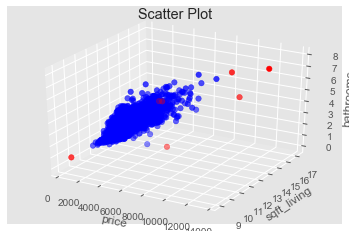

In [91]:
#3-dimention mahalanobis distance detect outliers
#The greater the value of mahalanobis distance, the higher probability of outlier it is.  

#build a new dataframe including three columns
hw=df_house[['price','sqft_living','bathrooms']]    
  
n_outliers = 7 #select 7 outliers 
#iloc[]take 3 columns and 1 row   hw.mean()here is an array of three variables    np.mat(hw.cov().as_matrix()).I is the inverse matrix of covariance   **为乘方  
#Series's output is: the index is on the left, the value is on the right
#m_dist_order is a one-dimensional array that holds the index in descending order of Series
m_dist_order =  Series([float(distance.mahalanobis(hw.iloc[i], hw.mean(), np.mat(hw.cov().as_matrix()).I) ** 2)  
       for i in range(len(hw))]).sort_values(ascending=False).index.tolist()  
is_outlier = [False, ] * len(hw)
for i in range(n_outliers):#mahalanobis distance value is marked as True
    is_outlier[m_dist_order[i]] = True  

#outliers are displayed in red, others are displayed in blue
color = ['b', 'r']  
#turn True to 1, False to 0
pch = [1 if is_outlier[i] == True else 0 for i in range(len(is_outlier))]  
#turn 1 to 'r', turn 0 to 'b'
cValue = [color[is_outlier[i]] for i in range(len(is_outlier))]  

#plotting
fig = plt.figure()  
#using 3 dimention 
ax1 = fig.gca(projection='3d')  
#set title and labels
ax1.set_title('Scatter Plot')  
ax1.set_xlabel('price')  
ax1.set_ylabel('sqft_living')  
ax1.set_zlabel('bathrooms')  
#plot scatter plot
ax1.scatter(hw['sqft_living'], hw['price'], hw['bathrooms'],  s=30, c=cValue)  
plt.show()  

In [92]:
index_list2=[]
#pch return True to 1. Here we can find the index of the outliers 
for i in range(len(pch)):
    if pch[i]==1:
        index_list2.append(i)

In [93]:
index_list2

[122, 2286, 2654, 3209, 4346, 4350, 4351]

In [94]:
#show outliers from 3-dimention mahalanobis distance
df_house.iloc[index_list2]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price_living
122,2014-05-05,14.639686,7,8.00,13540,307752,3.0,0,4,3,9410,4130,1999,NaN,26408 NE 70th St,Redmond,WA 98053,USA,0.001081
2286,2014-06-11,15.770310,5,4.50,10040,37325,2.0,1,2,3,7680,2360,1940,2001.0,4442 95th Ave NE,Bellevue,WA 98004,USA,0.001571
2654,2014-06-17,15.356241,5,6.75,9640,13068,1.0,1,4,3,4820,4820,1983,2009.0,5044 Butterworth Rd,Mercer Island,WA 98040,USA,0.001593
3209,2014-06-24,14.074522,0,0.00,4810,28008,2.0,0,0,3,4810,0,1990,NaN,20418 NE 64th Pl,Redmond,WA 98053,USA,0.002926
4347,2014-06-23,16.372660,3,2.50,2190,11394,1.0,0,0,3,1550,640,1956,NaN,5426 40th Ave W,Seattle,WA 98199,USA,0.007476
4351,2014-07-03,17.096046,3,2.00,1180,7793,1.0,0,0,4,1180,0,1992,NaN,12005 SE 219th Ct,Kent,WA 98031,USA,0.014488
4352,2014-05-06,8.961879,2,1.00,780,16344,1.0,0,0,1,780,0,1942,NaN,4229 S 144th St,Tukwila,WA 98168,USA,0.011490


7 outliers has been detected again! Campared with outliers that has been found from 2 dimention Mahalanobis distance, we have one more row(3209) detected and one less row(2328) undetected. It is not resonable to drop row 3209 here because it does not have any bedrooms and bathrooms. We can regards those 0 as missing values or even they truely does not have rooms in the real world. So it is hard to say. And another reson to keep it is that there are less indicators for housing price with no bedrooms and bathrooms. If we keep it, it can be regarded as one of the reference for someone who want to sell house without any interior decorations.

Here, I would like to regard outliers as missing values which have been found from 2-dimention Mahalanobis distance, so it would not influence the prediction models.

In [95]:
#Set values for particular cell in index_list
df_house.iloc[index_list1,1]=0
#replace 0 with NaN
df_house['price'].replace(0,np.NaN,inplace=True)

****

## Missing values

In terms of missing values, let's see what kind of missing values exists in the dataframe

In [96]:
df_house.isnull().sum()

date                0
price             255
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     4371
street              0
city                0
statezip            0
country             0
price_living      248
dtype: int64

The reason for existence of missing values:
* Missing at random in the collection process: Such as housing price, bathrooms, bedrooms.
* Missing intentionally in the collection process: Such as participants refusing to provide their yr_renovated.
* Missing because of a change of circumstances: Such as housing price sold twice.
* Missing pattern due to manual data entry procedure: Such as view and condition.

### Missing value - bedrooms, bathrooms and other column with 0s

We can not simply say that the column with 0 is missing value because those values might be 0 in the real word. For example, a house without a bedroom or bathroom or basement is normal and resonable. A house without bedrooms and bathrooms might be hotel or motel or department studios. And a house without basement is normal because poor people cannot afford basement. Therefore, based on the actual situation, data with zero should be justify with the fact when filling the missing values.

### Missing value - yr_renovated

The NaN of yr_renovate is missing completely at random. We cannot simply to fill the NaN because there are 2 reason that does not have year of renovate. First is that the seller of property deliberately hide the year of renovated. The reason might be that the owner have not renovated since they buy it, or the house have not been renovated for a long time. They hide this information might be this column is an optional they cannot remember the specific year. The second reason is that there is no general concept to define the year of renovated. For example, if I paint a wall, is it called renovated? And most importantly, government might not care about year of renovated when they calculating the property price growth. Therefore, it has a large number of missing values here. 

But if this project is used for property buyers, they might care about year of renovated. If we have to fill NaN compulsively, I would fill by the maximum number for either the median year of renovated or the year of property built. ACtually for this project, there is nearly no correlation between yr_renovated and housing price according to correlation matrx. And if we use price to predict year renovated, we cannot predict price by using yr_renovated again, That's also the reason why missing at rondom value is not related to the vaiable which has missing data. 

### Missing value - Housing price

The most important part, price, which we need to replace missing values with predicted price. Those housing price are 0 must be missing values because in the real market, housing price should be a number greater than 0. Housing price here is missing at random (MAR). Its missingness is related to a particular variable, but it is not related to the value of the variable that has missing data. So it is not related to yr-renovated.

It is easy to consider numerial variables as factors such as 'price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition', 'sqft_above','sqft_basement' and 'yr_built'. But how can we consider the relationship in categorical variable such as location and price? At very beginning, I thought it could be divided into several states to predict housing price. But later I think this method is not very good because several states have some of cities with higher housing price and some with lower housing price. Seperated by states would cause housing price imbalances, and reduce the predict accurate analysis. And moreover, some of states just have a few of properties, the lesser property records might lead to prediction biased.

Therefore, I divide 44 cities into 4 parts, 11 cities per group, which sorted according to housing price. The first group is where has the lowest median housing price, and second group is where has the relative low median price, and third group is where has the relative high median price and last group with highest price. This method not only effectively avoid the problem that large and small cities have large difference in housing price for each state, but also rationally grouped large and prosperous cities together and samll and backward cities together.

##### 1. Handling with lowest housing price cities missing value

In [97]:
lowest_price_cities

[u'Skykomish',
 u'Pacific',
 u'Algona',
 u'SeaTac',
 u'Covington',
 u'Des Moines',
 u'Tukwila',
 u'Federal Way',
 u'Auburn',
 u'Milton',
 u'Kent']

In [98]:
#build a new dataframe that just contain the city which is in lowest_price_list
df_house_copy=df_house[df_house['city'].isin(lowest_price_cities)]
df_house_copy.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price_living
2,2014-05-02,12.742566,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA,0.006602
15,2014-05-02,12.398757,3,1.50,1200,9720,1.0,0,0,4,1200,0,1965,NaN,14034 SE 201st St,Kent,WA 98042,USA,0.010332
17,2014-05-02,12.814479,4,3.00,3110,7231,2.0,0,0,3,3110,0,1997,NaN,11224 SE 306th Pl,Auburn,WA 98092,USA,0.004120
18,2014-05-02,12.460521,3,1.75,1370,5858,1.0,0,0,3,1370,0,1987,NaN,1605 S 245th Pl,Des Moines,WA 98198,USA,0.009095
25,2014-05-02,12.560244,3,2.50,2090,10834,1.0,0,0,4,1360,730,1987,NaN,27736 23rd Avenue South,Federal Way,WA 98003,USA,0.006010


In [99]:
#copy a new dataframe which not impact on original dataframe when modify the data
lowestprice_house_dropna=df_house_copy.copy()
#create a new dataframe to replace missing values with NaN
df_house_impute1= lowestprice_house_dropna.copy()
#check how many NaN in dataframe
lowestprice_house_dropna.isnull().sum()

date               0
price             40
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
sqft_above         0
sqft_basement      0
yr_built           0
yr_renovated     669
street             0
city               0
statezip           0
country            0
price_living      38
dtype: int64

In [100]:
#drop rows with the price is NaN
lowestprice_house_dropna.dropna(subset=['price'],axis=0,inplace=True)

Counting number of NaN both the dataframe has now

In [101]:
lowestprice_house_dropna['price'].isnull().sum()

0

In [102]:
df_house_impute1['price'].isnull().sum()

40

Drop the column which is categorical variables

In [103]:
lm_for_impute = LinearRegression()
#select the feature which are numerical
lm_fitting_df=lowestprice_house_dropna[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
                         'sqft_above','sqft_basement','yr_built']]
df_house_impute1=df_house_impute1[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
                         'sqft_above','sqft_basement','yr_built']]

Draw a regression

In [104]:
lm_for_impute.fit(lm_fitting_df[[x for x in lm_fitting_df.columns if x != 'price']], lm_fitting_df['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Replace missing values with predicted data
\begin{equation}
y_i = \beta_0 + \beta_1 X_i + \epsilon_i
\end{equation}

In [105]:
df_house_impute1['price'][df_house_impute1['price'].isnull()] = lm_for_impute.predict(df_house_impute1.drop(['price'],axis=1))

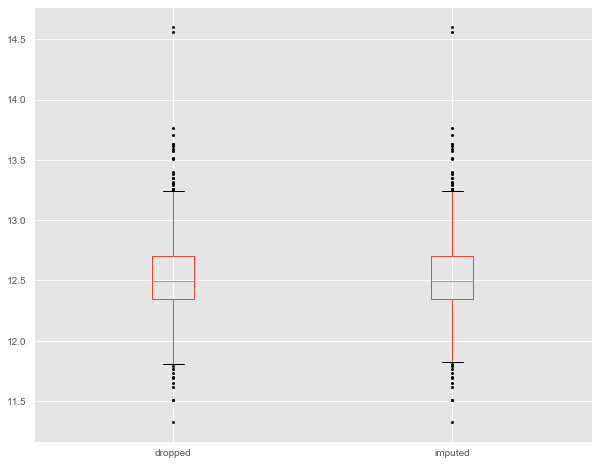

In [106]:
#draw boxplot
boxplot = pd.DataFrame({'imputed': df_house_impute1['price'],'dropped': lowestprice_house_dropna['price']})
boxplot.plot(kind='box', sym = 'k.',figsize=(10,8))
plt.show()

Test r-square

In [107]:
X_train, X_test, y_train, y_test = train_test_split(lm_fitting_df.iloc[:,1:],lm_fitting_df.iloc[:,:1],random_state=6)
lm_dropped = LinearRegression()
lm_dropped.fit(X_train,y_train)

print 'r-squared for this model = ',lm_dropped.score(X_test,y_test)

r-squared for this model =  0.685624846706


In [108]:
X_train, X_test, y_train, y_test = train_test_split(df_house_impute1.iloc[:,1:],df_house_impute1.iloc[:,:1],random_state=6)
lm_dropped = LinearRegression()
lm_dropped.fit(X_train,y_train)

print 'r-squared for this model = ',lm_dropped.score(X_test,y_test)

r-squared for this model =  0.743901119526


There are just 40 missing values has been predicted. It seems a good fit compared with dropna data set. 74% indicates that the model explains 74% the variability of the response data around its mean.

***

##### 2. Handling with Lower Price Cities Missing Values

In [109]:
low_price_cities

[u'Burien',
 u'Enumclaw',
 u'Black Diamond',
 u'Maple Valley',
 u'Renton',
 u'Shoreline',
 u'North Bend',
 u'Duvall',
 u'Inglewood-Finn Hill',
 u'Carnation',
 u'Vashon']

In [110]:
#build a new dataframe that just contain the city which is in low_price_list
df_house_copy=df_house[df_house['city'].isin(low_price_cities)]
df_house_copy.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price_living
0,2014-05-02,12.653958,3,1.5,1340,7912,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA,0.009443
7,2014-05-02,13.085699,4,2.5,2710,35868,2.0,0,0,3,2710,0,1989,NaN,23762 SE 253rd Pl,Maple Valley,WA 98038,USA,0.004829
8,2014-05-02,13.022543,3,2.5,2430,88426,1.0,0,0,4,1570,860,1985,NaN,46611-46625 SE 129th St,North Bend,WA 98045,USA,0.005359
19,2014-05-02,12.524526,3,1.5,1180,10277,1.0,0,0,3,1180,0,1983,NaN,12425 415th Ave SE,North Bend,WA 98045,USA,0.010614
33,2014-05-02,13.345507,4,2.5,2820,8408,2.0,0,0,3,2820,0,2014,NaN,17052 4th Ave NE,Shoreline,WA 98155,USA,0.004732


In [111]:
#copy a new dataframe which not impact on original dataframe when modify the data
lowprice_house_dropna=df_house_copy.copy()
#create a new dataframe to replace missing values with NaN
df_house_impute2= lowprice_house_dropna.copy()
#check how many NaN in dataframe
lowprice_house_dropna.isnull().sum()

date               0
price             43
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
sqft_above         0
sqft_basement      0
yr_built           0
yr_renovated     736
street             0
city               0
statezip           0
country            0
price_living      43
dtype: int64

In [112]:
#drop rows with the price is NaN
lowprice_house_dropna.dropna(subset=['price'],axis=0,inplace=True)

Counting number of NaN both the dataframe has now

In [113]:
lowprice_house_dropna['price'].isnull().sum()

0

In [114]:
df_house_impute2['price'].isnull().sum()

43

Drop the column which is categorical variables

In [115]:
lm_for_impute = LinearRegression()
lm_fitting_df=lowprice_house_dropna[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
                         'sqft_above','sqft_basement','yr_built']]
df_house_impute2=df_house_impute2[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
                         'sqft_above','sqft_basement','yr_built']]

Draw a regression

In [116]:
lm_for_impute.fit(lm_fitting_df[[x for x in lm_fitting_df.columns if x != 'price']], lm_fitting_df['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Replace missing values with predicted data
\begin{equation}
y_i = \beta_0 + \beta_1 X_i + \epsilon_i
\end{equation}

In [117]:
df_house_impute2['price'][df_house_impute2['price'].isnull()] = lm_for_impute.predict(df_house_impute2.drop(['price'],axis=1))

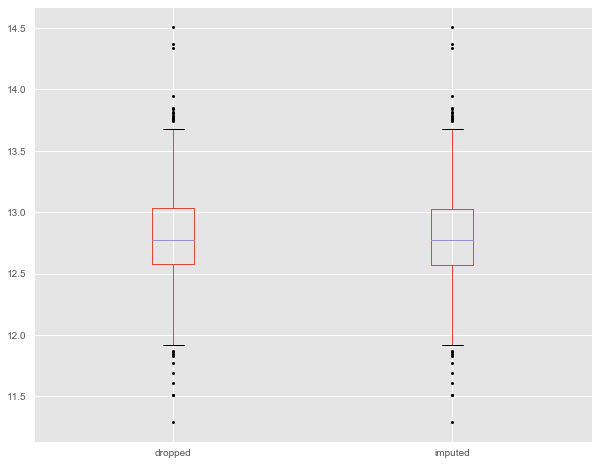

In [118]:
#draw boxplot
boxplot = pd.DataFrame({'imputed': df_house_impute2['price'],'dropped': lowprice_house_dropna['price']})
boxplot.plot(kind='box', sym = 'k.',figsize=(10,8))
plt.show()

Test r-square

In [119]:
X_train, X_test, y_train, y_test = train_test_split(lm_fitting_df.iloc[:,1:],lm_fitting_df.iloc[:,:1],random_state=9)
lm_dropped = LinearRegression()
lm_dropped.fit(X_train,y_train)

print 'r-squared for this model = ',lm_dropped.score(X_test,y_test)

r-squared for this model =  0.610116306991


In [120]:
X_train, X_test, y_train, y_test = train_test_split(df_house_impute2.iloc[:,1:],df_house_impute2.iloc[:,:1],random_state=6)
lm_dropped = LinearRegression()
lm_dropped.fit(X_train,y_train)

print 'r-squared for this model = ',lm_dropped.score(X_test,y_test)

r-squared for this model =  0.711056872216


There are just 43 missing values has been predicted. It seems a good fit compared with dropna data set. 71% indicates that the model explains 71% the variability of the response data around its mean.

*** 

##### 3. Handling with higher price cities missing value

In [121]:
high_price_cities

[u'Kenmore',
 u'Normandy Park',
 u'Bothell',
 u'Lake Forest Park',
 u'Seattle',
 u'Ravensdale',
 u'Kirkland',
 u'Snoqualmie Pass',
 u'Snoqualmie',
 u'Preston',
 u'Issaquah']

In [122]:
##build a new dataframe that just contain the city which is in high_price_list
df_house2=df_house[df_house['city'].isin(high_price_cities)]
df_house2.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price_living
1,2014-05-02,14.684290,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA,0.004023
5,2014-05-02,13.102161,2,1.00,880,6380,1.0,0,0,3,880,0,1938,1994.0,522 NE 88th St,Seattle,WA 98115,USA,0.014889
9,2014-05-02,13.369223,4,2.00,1520,6200,1.5,0,0,3,1520,0,1945,NaN,6811 55th Ave NE,Seattle,WA 98115,USA,0.008796
10,2014-05-02,13.045482,3,1.75,1710,7320,1.0,0,0,3,1710,0,1948,NaN,Burke-Gilman Trail,Lake Forest Park,WA 98155,USA,0.007629
11,2014-05-02,14.151983,4,2.50,2920,4000,1.5,0,0,5,1910,1010,1909,NaN,3838-4098 44th Ave NE,Seattle,WA 98105,USA,0.004847


In [123]:
#copy a new dataframe which not impact on original dataframe when modify the data
highprice_house_dropna=df_house2.copy()
#create a new dataframe to replace missing values with NaN
df_house_impute3= highprice_house_dropna.copy()
#check how many NaN in dataframe
highprice_house_dropna.isnull().sum()

date                0
price             106
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     2047
street              0
city                0
statezip            0
country             0
price_living      104
dtype: int64

In [124]:
#drop rows with the price is NaN
highprice_house_dropna.dropna(subset=['price'],axis=0,inplace=True)

Counting number of NaN both the dataframe has now

In [125]:
highprice_house_dropna['price'].isnull().sum()

0

In [126]:
df_house_impute3['price'].isnull().sum()

106

Drop the column which is categorical variables

In [127]:
lm_for_impute = LinearRegression()
lm_fitting_df=highprice_house_dropna[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
                         'sqft_above','sqft_basement','yr_built']]
df_house_impute3=df_house_impute3[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
                         'sqft_above','sqft_basement','yr_built']]

Draw a regression

In [128]:
lm_for_impute.fit(lm_fitting_df[[x for x in lm_fitting_df.columns if x != 'price']], lm_fitting_df['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Replace missing values with predicted data
\begin{equation}
y_i = \beta_0 + \beta_1 X_i + \epsilon_i
\end{equation}

In [129]:
df_house_impute3['price'][df_house_impute3['price'].isnull()] = lm_for_impute.predict(df_house_impute3.drop(['price'],axis=1))

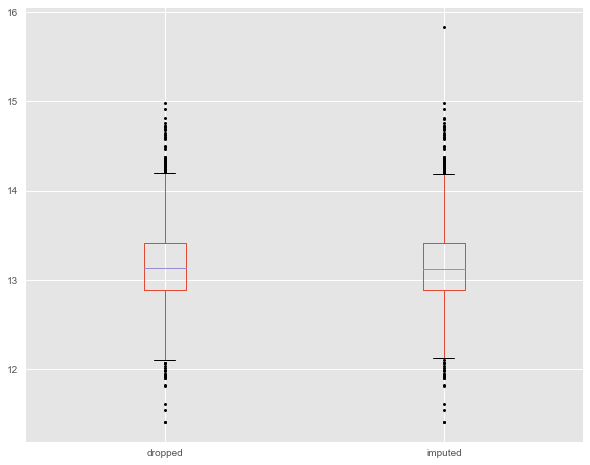

In [130]:
boxplot = pd.DataFrame({'imputed': df_house_impute3['price'],'dropped':highprice_house_dropna['price']})
boxplot.plot(kind='box', sym = 'k.',figsize=(10,8))
plt.show()

Test r-square

In [131]:
X_train, X_test, y_train, y_test = train_test_split(lm_fitting_df.iloc[:,1:],lm_fitting_df.iloc[:,:1],random_state=80)
lm_dropped = LinearRegression()
lm_dropped.fit(X_train,y_train)

print 'r-squared for this model = ',lm_dropped.score(X_test,y_test)

r-squared for this model =  0.618714404717


In [132]:
X_train, X_test, y_train, y_test = train_test_split(df_house_impute3.iloc[:,1:],df_house_impute3.iloc[:,:1],random_state=80)
lm_dropped = LinearRegression()
lm_dropped.fit(X_train,y_train)

print 'r-squared for this model = ',lm_dropped.score(X_test,y_test)

r-squared for this model =  0.657588066649


There are 106 missing values has been predicted - relatively large data set. It seems a good fit but very better than the previous two predictions. 65% indicates that the model explains 65% the variability of the response data around its mean.

***

##### 4. Handling with highest price cities missing value

In [133]:
highest_price_cities

[u'Fall City',
 u'Woodinville',
 u'Newcastle',
 u'Redmond',
 u'Sammamish',
 u'Bellevue',
 u'Beaux Arts Village',
 u'Mercer Island',
 u'Yarrow Point',
 u'Clyde Hill',
 u'Medina']

In [134]:
##build a new dataframe that just contain the city which is in highest_price_list
df_house2=df_house[df_house['city'].isin(highest_price_cities)]
df_house2.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price_living
3,2014-05-02,12.948010,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA,0.006474
4,2014-05-02,13.217674,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA,0.006813
6,2014-05-02,12.721886,2,2.00,1350,2560,1.0,0,0,3,1350,0,1976,NaN,2616 174th Ave NE,Redmond,WA 98052,USA,0.009424
12,2014-05-02,13.285332,3,1.75,2330,14892,1.0,0,0,3,1970,360,1980,NaN,1833 220th Pl NE,Sammamish,WA 98074,USA,0.005702
16,2014-05-02,12.945626,3,1.50,1570,6700,1.0,0,0,4,1570,0,1956,NaN,15424 SE 9th St,Bellevue,WA 98007,USA,0.008246


In [135]:
#copy a new dataframe which not impact on original dataframe when modify the data
highest_house_dropna=df_house2.copy()
#create a new dataframe to replace missing values with NaN
df_house_impute4= highest_house_dropna.copy()
#see how many NaN in dataframe
highest_house_dropna.isnull().sum()

date               0
price             66
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
sqft_above         0
sqft_basement      0
yr_built           0
yr_renovated     919
street             0
city               0
statezip           0
country            0
price_living      63
dtype: int64

In [136]:
#drop rows with the price is NaN
highest_house_dropna.dropna(subset=['price'],axis=0,inplace=True)

Counting number of NaN both the dataframe has now

In [137]:
highest_house_dropna['price'].isnull().sum()

0

In [138]:
df_house_impute4['price'].isnull().sum()

66

Drop the column which is categorical variables

In [139]:
lm_for_impute = LinearRegression()
lm_fitting_df=highest_house_dropna[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
                         'sqft_above','sqft_basement','yr_built']]
df_house_impute4=df_house_impute4[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
                         'sqft_above','sqft_basement','yr_built']]

Draw a regression

In [140]:
lm_for_impute.fit(lm_fitting_df[[x for x in lm_fitting_df.columns if x != 'price']], lm_fitting_df['price'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Replace missing values with predicted data
\begin{equation}
y_i = \beta_0 + \beta_1 X_i + \epsilon_i
\end{equation}

In [141]:
df_house_impute4['price'][df_house_impute4['price'].isnull()] = lm_for_impute.predict(df_house_impute4.drop(['price'],axis=1))

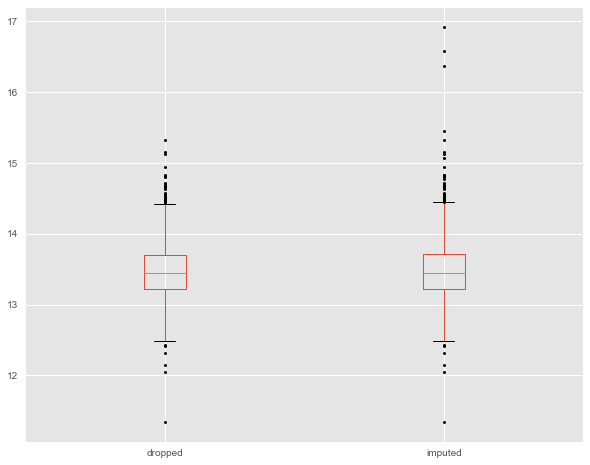

In [142]:
boxplot = pd.DataFrame({'imputed': df_house_impute4['price'],'dropped': highest_house_dropna['price']})
boxplot.plot(kind='box', sym = 'k.',figsize=(10,8))
plt.show()

Test r-square

In [143]:
X_train, X_test, y_train, y_test = train_test_split(lm_fitting_df.iloc[:,1:],lm_fitting_df.iloc[:,:1],random_state=6)
lm_dropped = LinearRegression()
lm_dropped.fit(X_train,y_train)

print 'r-squared for this model = ',lm_dropped.score(X_test,y_test)

r-squared for this model =  0.708660261207


In [144]:
X_train, X_test, y_train, y_test = train_test_split(df_house_impute4.iloc[:,1:],df_house_impute4.iloc[:,:1],random_state=6)
lm_dropped = LinearRegression()
lm_dropped.fit(X_train,y_train)

print 'r-squared for this model = ',lm_dropped.score(X_test,y_test)

r-squared for this model =  0.713009986193


There are 66 missing values has been predicted. It seems a good fit compared with dropna data set. 71% indicates that the model explains 71% the variability of the response data around its mean.

**** 

## Writing into a csv file

Replacing all the NaN values with Zero's in a column 

In [145]:
#merge the filled housing price dataframe
new_df=pd.concat([df_house_impute1, df_house_impute2,df_house_impute3,df_house_impute4], join='inner')
#set index back
new_df.sort_index(inplace=True)

In [146]:
#return column of exponential values
new_df['price']=np.exp(new_df['price'])
#change the price format to integer
new_df['price']=new_df['price'].astype(int)

In [147]:
#date dataframe
date=df_house[['date']]
#the rest of catagorial variable and yr_novatd dataframe
rest_of_column=df_house[['yr_renovated','street','city','statezip','country']]
#merge those dataframes
new_df=pd.concat([date, new_df,rest_of_column], axis=1)

Change back to orginal data format

In [148]:
new_df['date'] = new_df['date'].dt.strftime('%Y%m%d')+str('T000000')

Final dataframe looks like

In [31]:
new_df

In [150]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4600 entries, 0 to 4600
Data columns (total 18 columns):
date             4600 non-null object
price            4600 non-null int32
bedrooms         4600 non-null int32
bathrooms        4600 non-null float64
sqft_living      4600 non-null int64
sqft_lot         4600 non-null int32
floors           4600 non-null float64
waterfront       4600 non-null int64
view             4600 non-null int64
condition        4600 non-null int64
sqft_above       4600 non-null int64
sqft_basement    4600 non-null int64
yr_built         4600 non-null int64
yr_renovated     229 non-null float64
street           4600 non-null object
city             4600 non-null object
statezip         4600 non-null object
country          4600 non-null object
dtypes: float64(3), int32(3), int64(7), object(5)
memory usage: 788.9+ KB


In [151]:
#writing into a csv file. index
new_df.to_csv('clean_data.csv', encoding='utf-8',index=False)

***

## Summary

From this project, we gengerally audit and clean the loaded data from the dat file.
* Task1: Parsing the property sales data stored in “data.dat”

        * Examine and load the data into a Pandas DataFrame.
        * Parse the loaded data so that each sales record which corresponding to the table attributes
        
        
* Task2: Auditing and cleansing the loaded data

        * Irregularities
        * Lexical errors
        * Violations of the Integrity constraint, Inconsistency and Semantic errors
        * Duplications
        * Outliers
        * Missing values
* Loading into a csv file
